In [1]:
import torch

In [2]:
graphs = torch.load('data/datasets/gas_649_max_sigma5_int/graphs.pt')
graphs

/tmp/ipykernel_1572223/463437891.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load('data/datasets/gas_649_max_sigma5_int/graphs.pt')


[Data(x=[4539, 42], edge_index=[2, 18272], edge_attr=[18044, 33], y=[900], smiles='COC(=O)CCc1cc(OC)c(C(C)(C)C)cc1-c1ccc[nH]c1=O', symbol=[117]),
 Data(x=[1046, 42], edge_index=[2, 4232], edge_attr=[4132, 33], y=[900], smiles='Cc1cc(O)ccc1CC(=O)O', symbol=[54]),
 Data(x=[921, 42], edge_index=[2, 3726], edge_attr=[3634, 33], y=[900], smiles='COC(=O)c1ccc(N)n1C', symbol=[51]),
 Data(x=[2734, 42], edge_index=[2, 11010], edge_attr=[10858, 33], y=[900], smiles='Oc1ccc(-c2cc(F)c3c(Cl)c(O)ccc3c2Cl)cc1', symbol=[82]),
 Data(x=[2636, 42], edge_index=[2, 10640], edge_attr=[10468, 33], y=[900], smiles='CN(C)c1ccc(Cc2n[nH]c3ncc(Br)cc23)cc1', symbol=[86]),
 Data(x=[1704, 42], edge_index=[2, 6850], edge_attr=[6746, 33], y=[900], smiles='COC(=O)c1ccc(C(F)(F)Cl)nc1C', symbol=[64]),
 Data(x=[154, 42], edge_index=[2, 630], edge_attr=[594, 33], y=[900], smiles='CC(C)=O', symbol=[22]),
 Data(x=[2149, 42], edge_index=[2, 8666], edge_attr=[8518, 33], y=[900], smiles='C=C(C(=O)OCC)c1ccc(OC)cc1OC', symbol=[79

In [3]:
import networkx as nx
from torch_geometric.utils import to_networkx

graph = graphs[0]
G = to_networkx(graph)

/home/jose/simg_ir/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [4]:
# Create a more structured representation of the molecular graph
info = {
    "atom": [],       # List of atom objects with properties
    "bond": [],       # List of bond objects connecting atoms
    "lone_pair": [],  # List of lone pair objects
    "interaction": [] # List of interaction objects
}

lookup = {}

# First pass: identify and create atoms
for i in range(len(graph.symbol)):
    if graph.symbol[i] not in ["BND", "LP"]:
        d = {
            "idx": i,
            "type": "atom",
            "symbol": graph.symbol[i],
        }
        info["atom"].append(d)
        lookup[i] = d
        
# Second pass: create bonds, lone pairs, and interactions
atom_ids = [atom["idx"] for atom in info["atom"]]

for i in range(len(graph.x)):
    if i < len(graph.symbol):
        if graph.symbol[i] == "BND":
            connected_atoms = list(set(G.neighbors(i)).intersection(set(atom_ids)))
            d = {
                "idx": i,
                "type": "bond",
                "nbrs": connected_atoms
            }
            info["bond"].append(d)
            lookup[i] = d
        elif graph.symbol[i] == "LP":
            connected_atoms = list(set(G.neighbors(i)).intersection(set(atom_ids)))
            d = {
                "idx": i,
                "type": "lone_pair",
                "nbrs": connected_atoms
            }
            info["lone_pair"].append(d)
            lookup[i] = d
    else:
        neighbors = list(G.neighbors(i))
        d = {
            "idx": i,
            "type": "interaction",
            "nbrs": neighbors
        }
        info["interaction"].append(d)
        lookup[i] = d


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Create RDKit mol object from SMILES and add hydrogens
mol = Chem.MolFromSmiles(graph.smiles)
mol = Chem.AddHs(mol)

# Generate 2D coordinates
AllChem.Compute2DCoords(mol)

conf = mol.GetConformer()
coords_2d = []

for i in range(mol.GetNumAtoms()):
    pos = conf.GetAtomPosition(i)
    coords_2d.append(np.array([pos.x, pos.y]))

In [8]:
for atom_dict in info["atom"]:
    atom_dict["pos"] = coords_2d[atom_dict["idx"]]

In [9]:
for bond_dict in info["bond"]:
    nbrs = bond_dict["nbrs"]
    nbr1 = nbrs[0]
    pos1 = lookup[nbr1]["pos"]
    nbr2 = nbrs[1]
    pos2 = lookup[nbr2]["pos"]
    bond_dict["pos"] = (pos1 + pos2) / 2

In [10]:
for lone_pair_dict in info["lone_pair"]:
    nbrs = lone_pair_dict["nbrs"]
    nbr = nbrs[0]
    pos = lookup[nbr]["pos"]
    # Add small Gaussian noise to position the lone pair slightly away from the atom
    import numpy as np
    noise = np.random.normal(0, 0.2, 2)  # Mean 0, std 0.2, for both x and y
    lone_pair_dict["pos"] = pos + noise

/tmp/ipykernel_1570311/590064855.py:39: RuntimeWarning: invalid value encountered in divide
  perpendicular = perpendicular / np.linalg.norm(perpendicular) * np.linalg.norm(direction) * 0.3


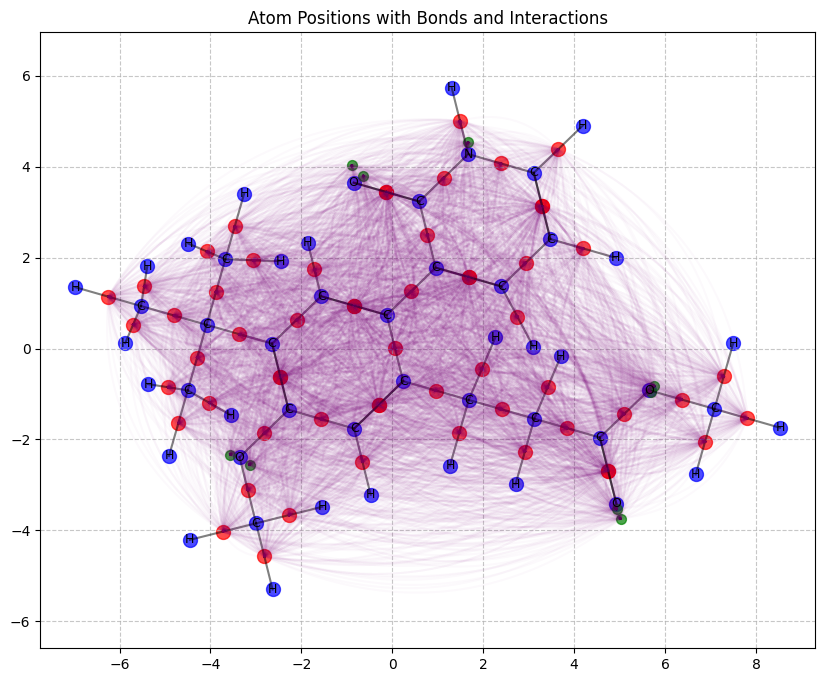

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

# Extract positions from atom dictionaries
atom_positions = np.array([atom_dict["pos"] for atom_dict in info["atom"]]) 
bond_positions = np.array([bond_dict["pos"] for bond_dict in info["bond"]])
lone_pair_positions = np.array([lone_pair_dict["pos"] for lone_pair_dict in info["lone_pair"]])

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(atom_positions[:, 0], atom_positions[:, 1], s=100, c='blue', alpha=0.7)
plt.scatter(bond_positions[:, 0], bond_positions[:, 1], s=100, c='red', alpha=0.7)
plt.scatter(lone_pair_positions[:, 0], lone_pair_positions[:, 1], s=50, c='green', alpha=0.7)

# Add labels for atoms
for i, atom_dict in enumerate(info["atom"]):
    plt.text(atom_dict["pos"][0], atom_dict["pos"][1], str(atom_dict["symbol"]), 
             fontsize=9, ha='center', va='center')

# Add bond edges
for bond_dict in info["bond"]:
    nbrs = bond_dict["nbrs"]
    atom1_pos = lookup[nbrs[0]]["pos"]
    atom2_pos = lookup[nbrs[1]]["pos"]
    plt.plot([atom1_pos[0], atom2_pos[0]], [atom1_pos[1], atom2_pos[1]], 'k-', alpha=0.5)

# Draw interaction pairs as curved lines
for interaction in info["interaction"]:
    nbrs = interaction["nbrs"]
    pos1 = lookup[nbrs[0]]["pos"]
    pos2 = lookup[nbrs[1]]["pos"]
    
    # Calculate midpoint with an offset to create a curved line
    midpoint = (pos1 + pos2) / 2
    # Create perpendicular vector for the control point
    direction = pos2 - pos1
    perpendicular = np.array([-direction[1], direction[0]])  # Rotate 90 degrees
    perpendicular = perpendicular / np.linalg.norm(perpendicular) * np.linalg.norm(direction) * 0.3
    
    # Control point for the curve
    control_point = midpoint + perpendicular
    
    # Create curved path
    t = np.linspace(0, 1, 100)
    # Quadratic Bezier curve
    curve_x = (1-t)**2 * pos1[0] + 2*(1-t)*t * control_point[0] + t**2 * pos2[0]
    curve_y = (1-t)**2 * pos1[1] + 2*(1-t)*t * control_point[1] + t**2 * pos2[1]
    
    # Plot the curved line
    plt.plot(curve_x, curve_y, 'purple', linestyle='-', linewidth=1.5, alpha=0.025)

plt.title("Atom Positions with Bonds and Interactions")
plt.axis('equal')  # Equal aspect ratio
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


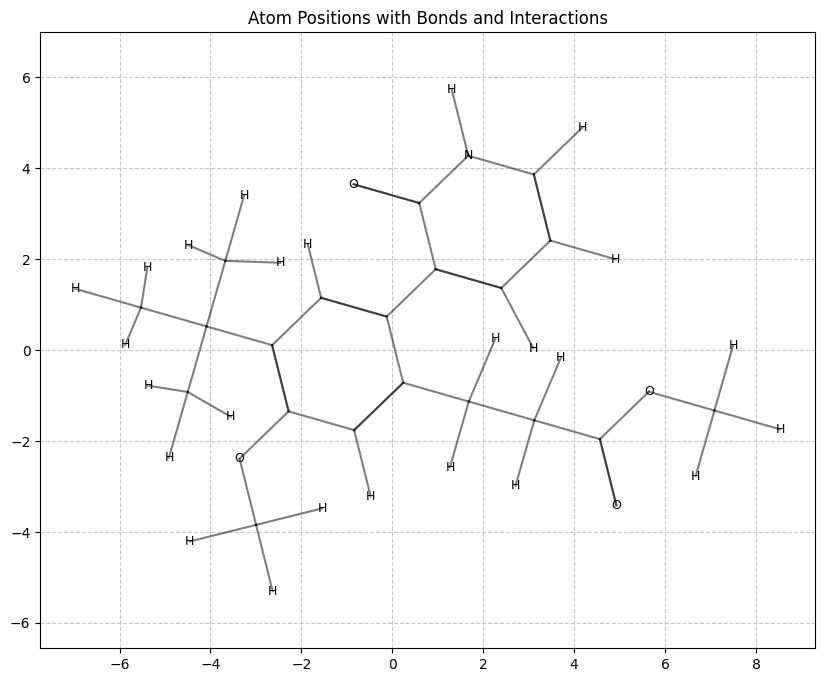

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

# Extract positions from atom dictionaries
atom_positions = np.array([atom_dict["pos"] for atom_dict in info["atom"]]) 
bond_positions = np.array([bond_dict["pos"] for bond_dict in info["bond"]])
lone_pair_positions = np.array([lone_pair_dict["pos"] for lone_pair_dict in info["lone_pair"]])

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(atom_positions[:, 0], atom_positions[:, 1], s=100, c='white', alpha=0)

# Add labels for atoms
for i, atom_dict in enumerate(info["atom"]):
    if atom_dict["symbol"] != "C":
        plt.text(atom_dict["pos"][0], atom_dict["pos"][1], str(atom_dict["symbol"]), 
             fontsize=9, ha='center', va='center')

# Add bond edges
for bond_dict in info["bond"]:
    nbrs = bond_dict["nbrs"]
    atom1_pos = lookup[nbrs[0]]["pos"]
    atom2_pos = lookup[nbrs[1]]["pos"]
    plt.plot([atom1_pos[0], atom2_pos[0]], [atom1_pos[1], atom2_pos[1]], 'k-', alpha=0.5)

# # Draw interaction pairs as curved lines
# for interaction in info["interaction"]:
#     nbrs = interaction["nbrs"]
#     pos1 = lookup[nbrs[0]]["pos"]
#     pos2 = lookup[nbrs[1]]["pos"]
    
#     # Calculate midpoint with an offset to create a curved line
#     midpoint = (pos1 + pos2) / 2
#     # Create perpendicular vector for the control point
#     direction = pos2 - pos1
#     perpendicular = np.array([-direction[1], direction[0]])  # Rotate 90 degrees
#     perpendicular = perpendicular / np.linalg.norm(perpendicular) * np.linalg.norm(direction) * 0.3
    
#     # Control point for the curve
#     control_point = midpoint + perpendicular
    
#     # Create curved path
#     t = np.linspace(0, 1, 100)
#     # Quadratic Bezier curve
#     curve_x = (1-t)**2 * pos1[0] + 2*(1-t)*t * control_point[0] + t**2 * pos2[0]
#     curve_y = (1-t)**2 * pos1[1] + 2*(1-t)*t * control_point[1] + t**2 * pos2[1]
    
#     # Plot the curved line
#     plt.plot(curve_x, curve_y, 'purple', linestyle='-', linewidth=1.5, alpha=0.025)

plt.title("Atom Positions with Bonds and Interactions")
plt.axis('equal')  # Equal aspect ratio
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [124]:
interaction_pairs

array([[ 50,  51],
       [ 50,  52],
       [ 50,  53],
       ...,
       [116, 113],
       [116, 114],
       [116, 115]])

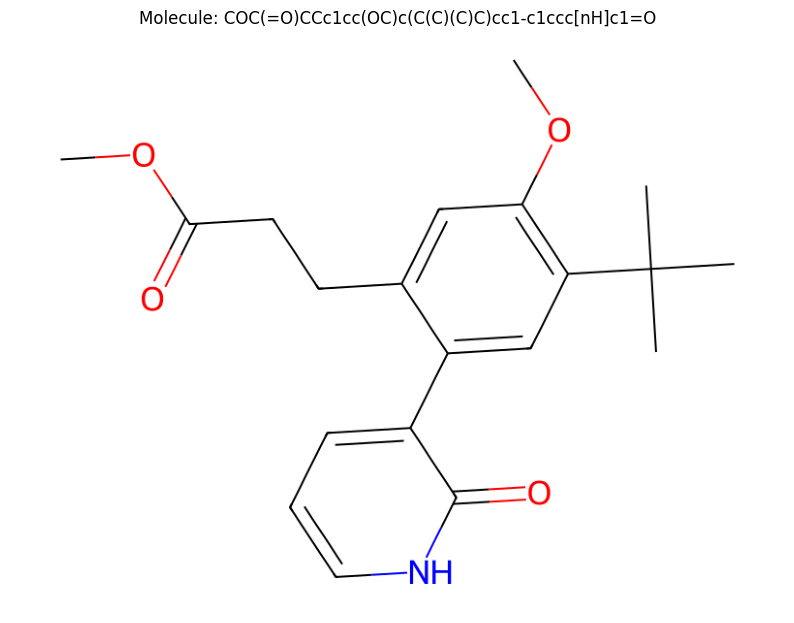

In [50]:
# Visualize the molecular structure using RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Convert SMILES to molecule
mol = Chem.MolFromSmiles(graph.smiles)
# Generate 2D coordinates
AllChem.Compute2DCoords(mol)

# Display the molecule
plt.figure(figsize=(10, 8))
img = Draw.MolToImage(mol, size=(800, 600))
plt.imshow(img)
plt.axis('off')
plt.title(f"Molecule: {graph.smiles}")
plt.show()

In [26]:
# Get the neighbors of node 1 in the graph
bond_idx = bond_indices[0]
neighbors = list(G.neighbors(bond_idx))
atom_neighbors = list(set(neighbors).intersection(set(atom_indices)))
print(f"Bond node {bond_idx} is connected to atoms: {atom_neighbors}")

# Get the symbols of these atoms
atom_symbols = [graphs[0].symbol[i] for i in atom_neighbors]
print(f"Connected atom symbols: {atom_symbols}")


Bond node 117 is connected to atoms: []
Connected atom symbols: []


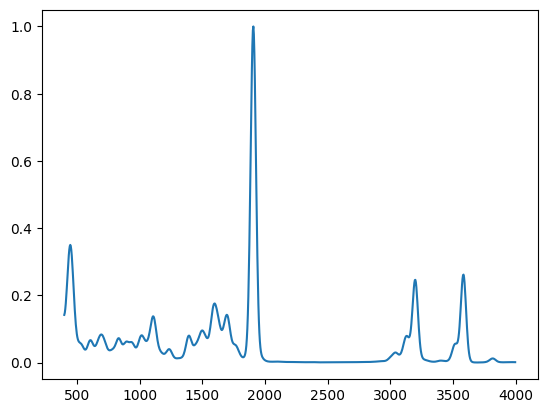

In [8]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(400, 4000, step=4), graphs[0].y)

In [15]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# Use inline backend
%matplotlib inline

# Load model and test set
dataset = "gas_649_max_sigma5_int"
checkpoint = torch.load(f"checkpoints/{dataset}/best_model.pt")
from experiments.downstream_model.model import GNN

model = GNN(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

dataset_path = os.path.join("data/datasets", dataset)
graphs = torch.load(os.path.join(dataset_path, "graphs.pt"), weights_only=False)

test_indices = torch.load(os.path.join(dataset_path, "split", "test_indices.pt"), weights_only=False)
test_subset = Subset(graphs, test_indices)
test_loader = DataLoader(test_subset, batch_size=32, num_workers=0)

# Get a batch from the test loader
batch = next(iter(test_loader))
x_axis = torch.arange(400, 4000, step=4)

# Function to calculate node importance using gradients
def calculate_node_importance(model, graph_data, wavenumber_idx):
    # Create a copy of the graph data as a single graph
    x = graph_data.x.clone().detach().requires_grad_(True)
    edge_index = graph_data.edge_index.clone().detach()
    edge_attr = graph_data.edge_attr.clone().detach()
    
    # Create a dummy batch index tensor
    batch_idx = torch.zeros(x.size(0), dtype=torch.long)
    
    # Forward pass
    model.zero_grad()
    output = model(x, edge_index, edge_attr, batch_idx)
    
    # Create a one-hot target for the specific wavenumber
    target = torch.zeros_like(output)
    target[0, wavenumber_idx] = 1.0
    
    # Calculate gradient w.r.t the specific wavenumber
    output[0, wavenumber_idx].backward(retain_graph=True)
    
    # Get gradients of input nodes
    node_importance = torch.abs(x.grad).sum(dim=1)
    
    return node_importance.detach().cpu().numpy()

def visualize_interactive_spectrum(graph_idx=0, top_n_nodes=5):
    # Get the graph from the test set
    graph_data = test_subset[graph_idx]
    
    # Create a copy for single graph prediction
    single_graph = graph_data.clone()
    
    # Run model prediction
    model.eval()
    with torch.no_grad():
        single_batch = torch.zeros(single_graph.x.size(0), dtype=torch.long)
        pred = model(single_graph.x, single_graph.edge_index, single_graph.edge_attr, single_batch)
    
    # Get prediction and ground truth
    prediction = pred.detach().cpu().numpy().flatten()
    ground_truth = graph_data.y.detach().cpu().numpy().flatten()
    
    # Extract data from the graph
    edge_index = graph_data.edge_index.cpu().numpy()
    node_features = graph_data.x.cpu().numpy()
    smiles = graph_data.smiles
    
    # Create networkx graph
    G = nx.Graph()
    
    # Get 2D coordinates using RDKit
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)
    
    # Assume the first N nodes are atoms
    num_atoms = mol.GetNumAtoms()
    
    # Build connectivity map
    connectivity = {}
    for i in range(edge_index.shape[1]):
        src, dst = int(edge_index[0, i]), int(edge_index[1, i])
        if src not in connectivity:
            connectivity[src] = []
        if dst not in connectivity:
            connectivity[dst] = []
        connectivity[src].append(dst)
        connectivity[dst].append(src)
    
    # Add atom nodes
    for i in range(num_atoms):
        atom = mol.GetAtomWithIdx(i)
        label = atom.GetSymbol()
        pos = mol.GetConformer().GetAtomPosition(i)
        position = (pos.x, pos.y)
        G.add_node(i, pos=position, node_type='atom', label=label)
    
    # Calculate scale factor
    positions = np.array([(mol.GetConformer().GetAtomPosition(i).x, 
                           mol.GetConformer().GetAtomPosition(i).y) 
                          for i in range(num_atoms)])
    x_range = np.max(positions[:, 0]) - np.min(positions[:, 0])
    y_range = np.max(positions[:, 1]) - np.min(positions[:, 1])
    scale = max(x_range, y_range) * 0.08
    
    # Add non-atom nodes
    for i in range(num_atoms, node_features.shape[0]):
        connected_atoms = [j for j in connectivity.get(i, []) if j < num_atoms]
        
        if len(connected_atoms) >= 2:
            node_type = 'bond'
            label = ''
            
            valid_atoms = [j for j in connected_atoms if j < mol.GetNumAtoms()]
            
            if valid_atoms:
                atom_positions = [mol.GetConformer().GetAtomPosition(int(j)) for j in valid_atoms]
                position = (np.mean([p.x for p in atom_positions]), 
                           np.mean([p.y for p in atom_positions]))
            else:
                position = (0, 0)
        else:
            node_type = 'lone_pair'
            label = 'LP'
            
            if connected_atoms and connected_atoms[0] < mol.GetNumAtoms():
                atom_idx = int(connected_atoms[0])
                atom_pos = mol.GetConformer().GetAtomPosition(atom_idx)
                
                atom_lone_pairs = [n for n in connectivity.get(atom_idx, []) 
                                  if n >= num_atoms and n != i]
                
                lp_count = len(atom_lone_pairs)
                if lp_count > 0:
                    angle = 2 * np.pi * (lp_count / 4)
                else:
                    angle = np.pi/4
                    
                offset_x = scale * np.cos(angle)
                offset_y = scale * np.sin(angle)
                position = (atom_pos.x + offset_x, atom_pos.y + offset_y)
            else:
                position = (0, 0)
        
        G.add_node(i, pos=position, node_type=node_type, label=label)
    
    # Add atom-atom edges
    atom_edges = []
    for i in range(edge_index.shape[1]):
        src, dst = int(edge_index[0, i]), int(edge_index[1, i])
        if src < num_atoms and dst < num_atoms:
            G.add_edge(src, dst)
            atom_edges.append((src, dst))
    
    # Get positions for drawing
    pos = nx.get_node_attributes(G, 'pos')
    
    # Function to get index from wavenumber
    def wavenumber_to_index(wn):
        return int((wn - 400) / 4)
    
    # Create output widget for displaying plots
    output = widgets.Output()
    
    # Create the slider for selecting wavenumber
    wavenumber_slider = widgets.IntSlider(
        value=1500,
        min=400,
        max=3996,
        step=4,
        description='Wavenumber:',
        disabled=False,
        continuous_update=False,
        layout=widgets.Layout(width='80%')
    )
    
    # Function to draw a new visualization
    def draw_visualization(wavenumber):
        with output:
            clear_output(wait=True)
            
            # Create a new figure
            fig = plt.figure(figsize=(12, 10))
            gs = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)
            
            ax_mol = fig.add_subplot(gs[0, 0])
            ax_spec = fig.add_subplot(gs[1, 0])
            
            # Convert wavenumber to index for the model
            wn_idx = wavenumber_to_index(wavenumber)
            
            # Calculate node importance using gradients
            node_importance = calculate_node_importance(model, graph_data, wn_idx)
            
            # Get top influential nodes
            top_indices = np.argsort(np.abs(node_importance))[-top_n_nodes:]
            
            # Draw the molecule visualization
            # Draw edges
            nx.draw_networkx_edges(G, pos, ax=ax_mol, edgelist=atom_edges, 
                                  alpha=0.8, width=1.5, edge_color='blue')
            
            # Get node lists by type
            atom_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'atom']
            bond_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'bond']
            lone_pair_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'lone_pair']
            
            # Define colors and sizes
            atom_color = '#1f78b4'  # Blue
            bond_color = '#33a02c'  # Green
            lone_pair_color = '#ff7f00'  # Orange
            
            atom_size = 700
            bond_size = 300
            lp_size = 250
            
            # Create color and size lists
            atom_colors = [atom_color] * len(atom_nodes)
            bond_colors = [bond_color] * len(bond_nodes)
            lp_colors = [lone_pair_color] * len(lone_pair_nodes)
            
            atom_sizes = [atom_size] * len(atom_nodes)
            bond_sizes = [bond_size] * len(bond_nodes)
            lp_sizes = [lp_size] * len(lone_pair_nodes)
            
            # Update colors and sizes for influential nodes
            highlight_color = 'red'
            size_multiplier = 1.5
            
            for idx in top_indices:
                if idx in atom_nodes:
                    node_pos = atom_nodes.index(idx)
                    atom_colors[node_pos] = highlight_color
                    atom_sizes[node_pos] = atom_size * size_multiplier
                elif idx in bond_nodes:
                    node_pos = bond_nodes.index(idx)
                    bond_colors[node_pos] = highlight_color
                    bond_sizes[node_pos] = bond_size * size_multiplier
                elif idx in lone_pair_nodes:
                    node_pos = lone_pair_nodes.index(idx)
                    lp_colors[node_pos] = highlight_color
                    lp_sizes[node_pos] = lp_size * size_multiplier
            
            # Draw nodes with highlight effect
            nx.draw_networkx_nodes(G, pos, ax=ax_mol, nodelist=atom_nodes, 
                                  node_color=atom_colors, node_size=atom_sizes, 
                                  alpha=0.9, node_shape='o')
            
            nx.draw_networkx_nodes(G, pos, ax=ax_mol, nodelist=bond_nodes, 
                                  node_color=bond_colors, node_size=bond_sizes, 
                                  alpha=0.8, node_shape='s')
            
            nx.draw_networkx_nodes(G, pos, ax=ax_mol, nodelist=lone_pair_nodes, 
                                  node_color=lp_colors, node_size=lp_sizes, 
                                  alpha=0.8, node_shape='d')
            
            # Add labels only to atoms for clarity
            atom_labels = {n: G.nodes[n]['label'] for n in atom_nodes}
            nx.draw_networkx_labels(G, pos, ax=ax_mol, labels=atom_labels, font_size=12, font_color='black')
            
            # Add a legend
            atom_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=atom_color, 
                                   markersize=15, label='Atom')
            bond_patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=bond_color, 
                                   markersize=10, label='Bond')
            lp_patch = plt.Line2D([0], [0], marker='d', color='w', markerfacecolor=lone_pair_color, 
                                 markersize=10, label='Lone Pair')
            highlight_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                                       markersize=15, label=f'Top {top_n_nodes} Influential Nodes')
            
            ax_mol.legend(handles=[atom_patch, bond_patch, lp_patch, highlight_patch], 
                        loc='upper right', frameon=True)
            
            ax_mol.set_title(f"Molecule: {smiles}\nWavenumber: {wavenumber} cm⁻¹", fontsize=14)
            ax_mol.axis('off')
            
            # Draw the spectrum
            ax_spec.plot(x_axis, prediction, color="#E8945A", label="Prediction")
            ax_spec.plot(x_axis, ground_truth, color="#5BB370", label="Ground Truth")
            
            # Draw vertical line at selected wavenumber - FIXED: using array instead of single value
            ax_spec.axvline(x=wavenumber, color='r', linestyle='--')
            
            ax_spec.set_xlabel('Wavenumber (cm⁻¹)')
            ax_spec.set_ylabel('Intensity')
            ax_spec.set_title('IR Spectrum Comparison')
            ax_spec.legend()
            
            plt.tight_layout()
            plt.show()
    
    # Connect interactive elements
    def on_slider_change(change):
        if change['name'] == 'value':
            draw_visualization(change['new'])
    
    # Register callback
    wavenumber_slider.observe(on_slider_change, names='value')
    
    # Initial visualization
    draw_visualization(wavenumber_slider.value)
    
    # Display the slider and output area
    display(widgets.VBox([wavenumber_slider, output]))
    
    return G, pos

# Call the function to visualize
G, pos = visualize_interactive_spectrum(graph_idx=0)

/tmp/ipykernel_2321432/3957714066.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"checkpoints/{dataset}/best_model.pt")


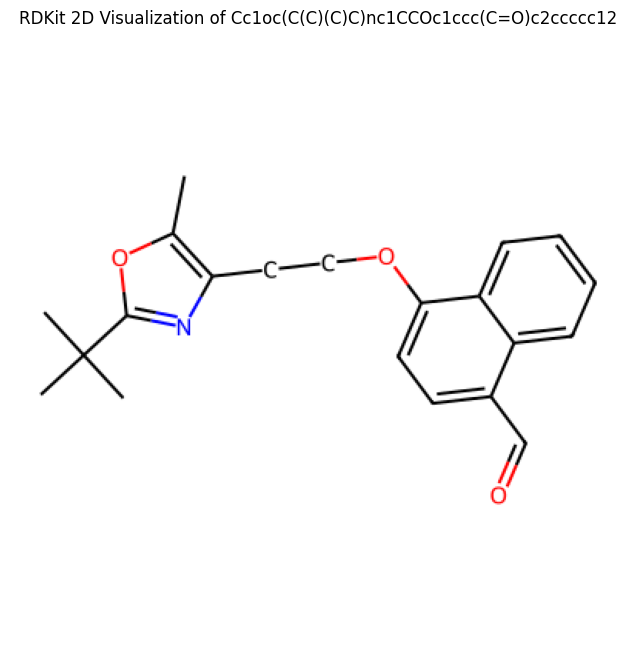

In [10]:
# Visualize the same molecule using RDKit
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# Get the SMILES string from the graph
smiles = "Cc1oc(C(C)(C)C)nc1CCOc1ccc(C=O)c2ccccc12"

# Create RDKit molecule from SMILES
mol = Chem.MolFromSmiles(smiles)

# Generate 2D coordinates for the molecule
mol = Chem.AddHs(mol)
AllChem.Compute2DCoords(mol)
mol = Chem.RemoveHs(mol)

# Create the drawing
img = Draw.MolToImage(mol, size=(400, 400))

# Display the molecule
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"RDKit 2D Visualization of {smiles}")
plt.show()


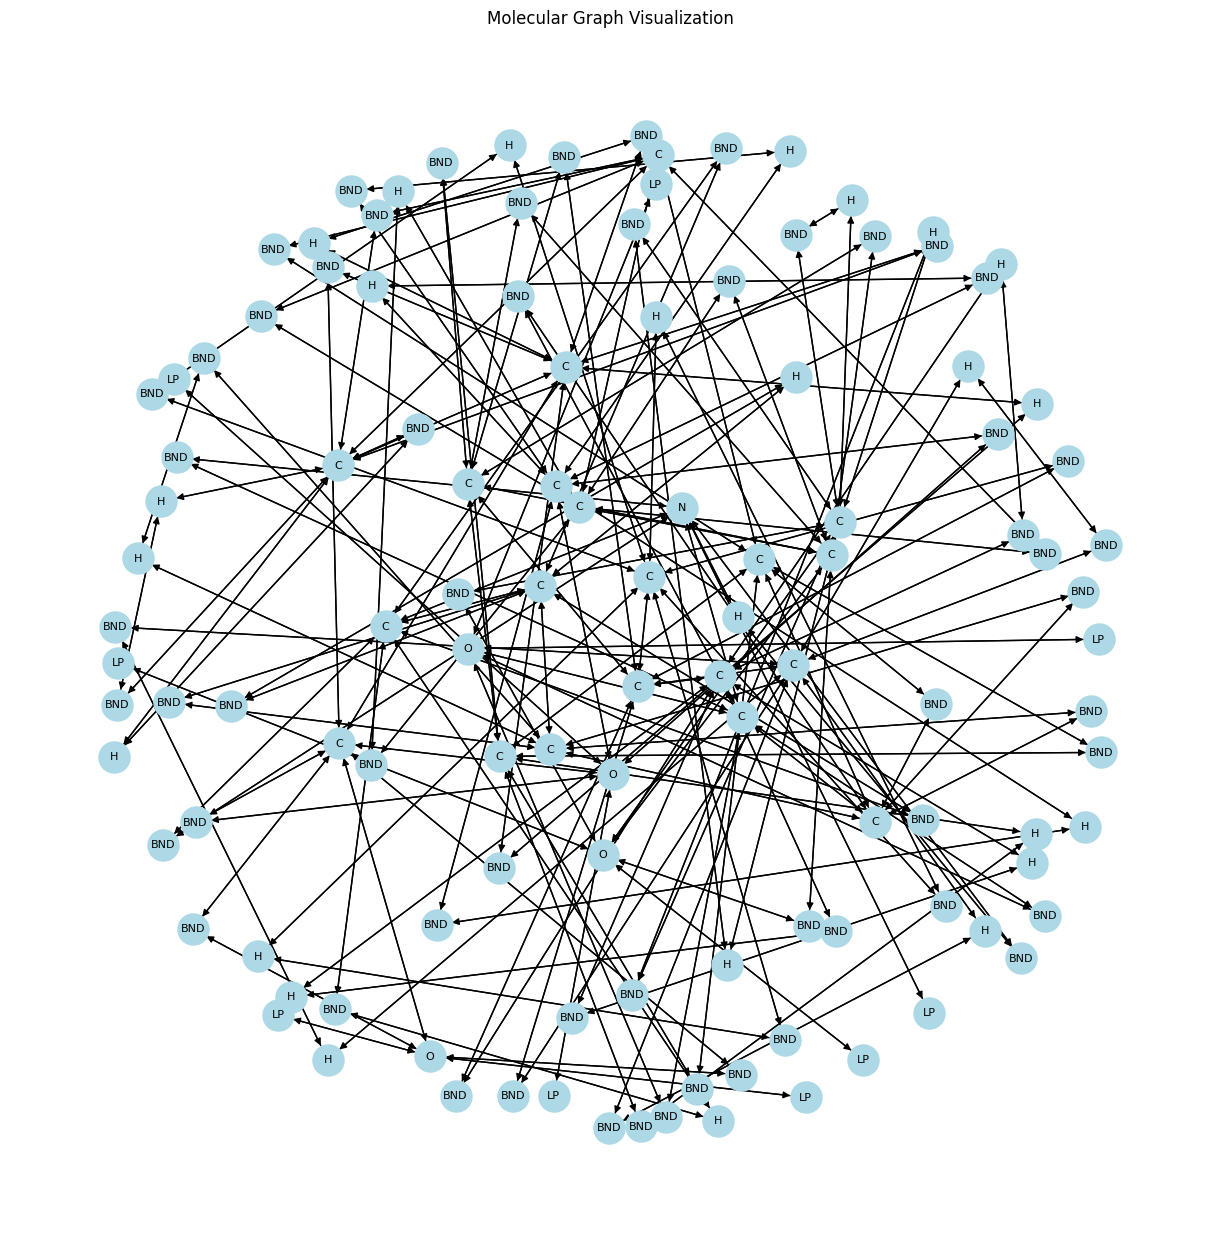

In [12]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Get first graph's symbols and node count
graph = graphs[0]
symbols = graph.symbol

# Create subgraph with only molecular nodes
molecular_nodes = list(range(len(symbols)))
G = to_networkx(graph)
G = G.subgraph(molecular_nodes)

# Create labels dictionary for molecular nodes
labels = {i: symbols[i] for i in range(len(symbols))}

# Set up plot
plt.figure(figsize=(12,12))

# Draw graph with labels
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=500,
        with_labels=True,
        labels=labels,
        font_size=8)

plt.title("Molecular Graph Visualization")
plt.show()


In [13]:
import numpy as np
import networkx as nx
from torch_geometric.utils import to_networkx
from tqdm import tqdm

# Function to find the largest connected component size for each graph
def get_largest_connected_component_size(graph):
    # Convert PyG graph to NetworkX graph (only considering atom-atom connections)
    G = to_networkx(graph, to_undirected=True)
    
    # Find connected components
    connected_components = list(nx.connected_components(G))
    
    # Return size of largest component (or 0 if no components)
    if connected_components:
        return max(len(component) for component in connected_components)
    else:
        return 0

# Calculate largest connected component size for each graph
largest_cc_sizes = []
for graph in tqdm(graphs, desc="Analyzing graphs"):
    largest_cc_sizes.append(get_largest_connected_component_size(graph))

# Display statistics
print(f"Average largest connected component size: {np.mean(largest_cc_sizes):.2f}")
print(f"Median largest connected component size: {np.median(largest_cc_sizes):.2f}")
print(f"Min largest connected component size: {min(largest_cc_sizes)}")
print(f"Max largest connected component size: {max(largest_cc_sizes)}")

# Plot histogram of largest connected component sizes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(largest_cc_sizes, bins=20, alpha=0.7)
plt.xlabel('Size of Largest Connected Component')
plt.ylabel('Number of Graphs')
plt.title('Distribution of Largest Connected Component Sizes')
plt.grid(alpha=0.3)
plt.show()


Analyzing graphs:  27%|██▋       | 175/649 [00:09<00:16, 28.47it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4e5c28c820>>
Traceback (most recent call last):
  File "/home/jose/simg_ir/.venv/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Analyzing graphs:  70%|██████▉   | 454/649 [00:21<00:07, 26.45it/s]

: 

: 

In [7]:
node_len = [len(graph.x) for graph in graphs]
node_len

[4539,
 1046,
 921,
 2734,
 2636,
 1704,
 154,
 2149,
 690,
 379,
 698,
 587,
 2146,
 743,
 377,
 454,
 2952,
 5431,
 2848,
 2838,
 2948,
 1539,
 1967,
 55,
 1548,
 859,
 5984,
 3898,
 237,
 1049,
 3641,
 1793,
 4810,
 1393,
 5674,
 416,
 1624,
 372,
 3753,
 5526,
 381,
 1626,
 859,
 3524,
 2245,
 2230,
 3399,
 2952,
 4271,
 2054,
 5081,
 1108,
 2741,
 5375,
 3757,
 5094,
 4671,
 3177,
 2336,
 3058,
 4797,
 1705,
 3892,
 5086,
 1970,
 1393,
 2535,
 749,
 4011,
 1968,
 1244,
 5226,
 6138,
 1048,
 1392,
 1790,
 4139,
 5521,
 1471,
 5379,
 1881,
 4011,
 2051,
 3174,
 3523,
 5673,
 802,
 1703,
 4537,
 858,
 5092,
 1794,
 925,
 4140,
 1110,
 6298,
 1789,
 1623,
 497,
 919,
 3060,
 4009,
 1174,
 6141,
 2338,
 1551,
 3763,
 4135,
 1706,
 3065,
 1320,
 744,
 2529,
 6297,
 3061,
 1177,
 3764,
 2248,
 1247,
 1397,
 3395,
 1468,
 1045,
 3063,
 4944,
 1958,
 1245,
 1112,
 2139,
 2151,
 1966,
 6466,
 1250,
 2153,
 2145,
 2144,
 1624,
 1879,
 1877,
 2534,
 2627,
 1880,
 2952,
 2628,
 2432,
 1115,
 5

In [8]:
node_len == largest_cc_sizes

True

In [16]:
# Function to visualize a graph with node labels
def visualize_graph(graph_idx):
    graph = graphs[graph_idx]
    
    # Convert PyG graph to NetworkX graph
    G = to_networkx(graph, to_undirected=True)
    
    # Get positions for nodes
    pos = nx.spring_layout(G, seed=42)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=10, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    
    # Add node labels using symbol information
    # Fix: handle both tensor and string symbol types
    labels = {}
    for i in range(len(graph.symbol)):
        if hasattr(graph.symbol[i], 'item'):
            labels[i] = graph.symbol[i].item()
        else:
            labels[i] = graph.symbol[i]  # Use as is if it's already a string
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    
    plt.title(f"Graph {graph_idx} - SMILES: {graph.smiles}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
